In [ ]:
#TODO import
import tensorflow as tf
import numpy as np
# import cv2 as cv2

import matplotlib.pyplot as plt
%matplotlib inline

import os

In [6]:
#TODO Load CSV
# DO NOT RUN UNLESS EVERYTHING HAS BEEN CHANGED, YOU WILL REGRET IT

tfilename = './SampleData/emnist-bymerge-train.csv'
raw_data = open(tfilename, 'rt')
data = np.loadtxt(raw_data, delimiter=',', skiprows=500000)
model_name = "emnist"
print(data.shape)

# DO NOT RUN UNLESS EVERYTHING HAS BEEN CHANGED, YOU WILL REGRET IT

eval_file = './SampleData/emnist-bymerge-test.csv'
eval_raw_data = open(eval_file, 'rt')
eval_data = np.loadtxt(eval_raw_data, delimiter=',')
print(eval_data.shape)

# DO NOT RUN UNLESS EVERYTHING HAS BEEN CHANGED, YOU WILL REGRET IT

(197932, 785)


(116323, 785)


In [7]:



# testletter = data[0][:]
# label = testletter[0]
# print(label)
# letterimage = np.reshape(testletter[1:], (28,28))
# letter_part = np.transpose(letterimage, [1, 0])
# plt.matshow(letter_part, cmap='gray')
# plt.show()


In [8]:
#TODO Process Training Data
image_height = 28
image_width = 28

color_channels = 1
print("Train data:")
train_data = data[:, 1:]
print(train_data.shape)
train_labels = data[:, 0]
print(train_labels.shape)

print("Eval data:")
# print(eval_data.shape)
eval_imgs = eval_data[:, 1:]
print(eval_imgs.shape)
eval_labels = eval_data[:, 0]
print(eval_labels.shape)



def process_data(indata):
    reshaped = np.reshape(indata, (-1, 28, 28, 1))
    return np.transpose(reshaped, [0,2,1,3])
    # return reshaped

print("Reshaped:")

train_data = process_data(train_data)
print("Train: "+ str(train_data.shape))

eval_imgs = process_data(eval_imgs)
print("Eval: " + str(eval_imgs.shape))

# plt.matshow(eval_imgs[27,:,:,0], cmap='gray')



Train data:
(197932, 784)
(197932,)
Eval data:
(116323, 784)
(116323,)
Reshaped:
Train: (197932, 28, 28, 1)
Eval: (116323, 28, 28, 1)


In [13]:
#NN
class ConvNet:
    def __init__(self, image_height, image_width, channels, num_classes):
         
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels], name="inputs")
        print(self.input_layer.shape)
         
        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_1.shape)
         
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2,2], strides=2)
        print(pooling_layer_1.shape)
         
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=128, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        print(conv_layer_2.shape)

        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)
         
        flattened_pooling = tf.layers.flatten(pooling_layer_1)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        dropout = tf.layers.dropout(dense_layer, rate=0.6, training=True)
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
         
        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)
         
        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
         
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)     
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)
         
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-5)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())

In [14]:

# TODO: initialize variables
training_steps = 1000
batch_size = 512

path = "./" + model_name + "-cnn/"
 
load_checkpoint = True
performance_graph = np.array([])

In [15]:

tf.reset_default_graph()
 
dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()
 
dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()
 
cnn = ConvNet(image_height, image_width, color_channels, 47)
 
saver = tf.train.Saver(max_to_keep=2)
 
if not os.path.exists(path):
    os.makedirs(path)
     
with tf.Session() as sess:
     
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
     
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)
         
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
         
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
         
        if step % 100 == 0:
            performance_graph=np.append(performance_graph, sess.run(cnn.accuracy))
                                          
        if step % 100 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)
             
            print("Accuracy at step " + str(step) + ": " + str(current_acc * 100))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, step)
         
    print("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, step)
    # print(batch_inputs.shape)
    # print(batch_labels[9])
    # plt.matshow(batch_inputs[9,:,:,0], cmap='gray')


(?, 28, 28, 1)
(?, 28, 28, 64)
(?, 14, 14, 64)
(?, 14, 14, 128)
(?, 7, 7, 128)
(?, 1024)
(?, 47)


KeyboardInterrupt: 

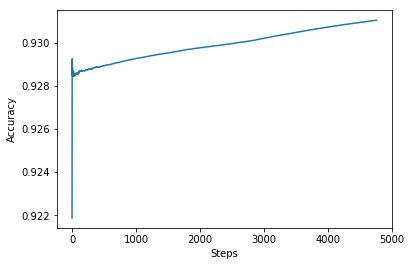

In [16]:

# TODO Display graph of data
plt.figure().set_facecolor('white')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.plot(performance_graph)

In [9]:

#TODO Eval Data
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess, checkpoint.model_checkpoint_path)
     
    sess.run(tf.local_variables_initializer())
     
    for image, label in zip(eval_imgs, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
     
    print(sess.run(cnn.accuracy))


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-99


KeyboardInterrupt: 

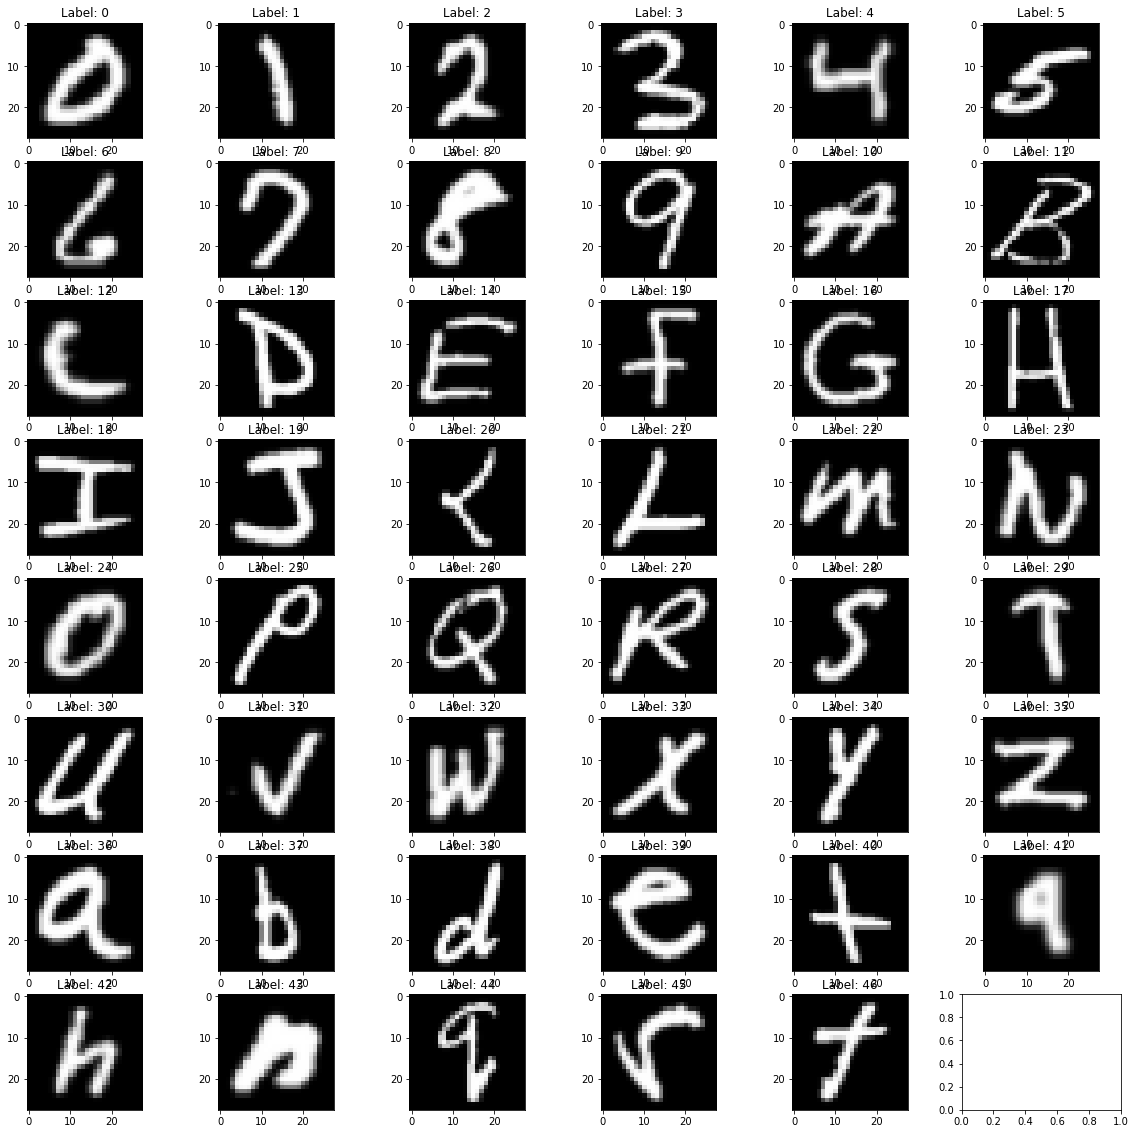

In [10]:
# TODO Get printout of each label
rows = 8
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.patch.set_facecolor('white')
image_count = 0

curr_label = 0
counter = 1

for idx, label in enumerate(train_labels):
    if label == curr_label:
        sub = plt.subplot(rows, cols, counter)
        img = train_data[idx]
        img = img.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        sub.set_title("Label: " + str(curr_label))
        curr_label += 1
        counter += 1

        

In [20]:
#TODO Change labels names
mydict = {}

for i in range(10):
    mydict[i] = str(i)
    
idx = 10
for j in range(65,91):
    mydict[idx] = chr(j)
    idx += 1

mydict[36] = "a"
mydict[37] = "b"
mydict[38] = "d"
mydict[39] = "e"
mydict[40] = "t"
mydict[41] = "q"
mydict[42] = "h"
mydict[43] = "n"
mydict[44] = "q"
mydict[45] = "r"
mydict[46] = "t"

print(mydict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 't', 41: 'q', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-999


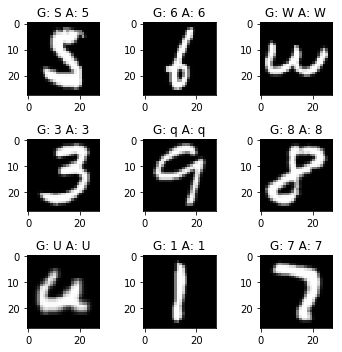

In [10]:
# TODO: Get a random set of images and make guesses for each
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    indexes = np.random.choice(len(train_data), 9, replace=False)
     
    rows = 3
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows, cols, image_count)
        img = train_data[idx]
        img = img.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[train_data[idx]]})
        guess_name = mydict[guess[0]]
        # guess_name = str(guess[0])
        # actual_name = str(train_labels[idx])
        actual_name = mydict[train_labels[idx]]
        sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()

In [17]:
# TODO: Take a picture with the webcam
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:
    ret, frame = cam.read()
    cv2.imshow("test", frame)
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "./SampleLetters/opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()


./SampleLetters/opencv_frame_0.png written!


./SampleLetters/opencv_frame_1.png written!
./SampleLetters/opencv_frame_2.png written!


Escape hit, closing...


In [18]:
#TODO Run For webcam
new_img = []

for i in range(3):
    img = cv2.imread(f'./SampleLetters/opencv_frame_{i}.png', 0)

    res = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    print(type(res))
    # res = np.expand_dims(res, axis=0)
    res = np.expand_dims(res, axis=2)
    # plt.imshow(res[0], cmap='gray')
    # plt.show()
    res = np.around(res, decimals=0)
    res = 1 - res
    print(res.shape)
    new_img.append(res)

new_imgs = np.asarray(new_img)
print(new_imgs.shape)


<class 'numpy.ndarray'>
(28, 28, 1)
<class 'numpy.ndarray'>
(28, 28, 1)
<class 'numpy.ndarray'>
(28, 28, 1)
(3, 28, 28, 1)


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-476000


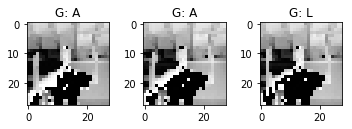

In [21]:
# TODO: Get webcam img and guess

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    # indexes = np.random.choice(len(new_imgs), 2, replace=False)
     
    rows = 1
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in range(3):
        image_count += 1
        sub = plt.subplot(rows, cols, image_count)
        imgs = new_imgs[idx]
        img = imgs.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[new_imgs[idx]]})
        guess_name = mydict[guess[0]]
        # guess_name = str(guess[0])
        # actual_name = str(train_labels[idx])
        actual_name = mydict[train_labels[idx]]
        sub.set_title("G: " + guess_name)
        
    plt.tight_layout()


In [22]:
#Pixel
img = cv2.imread("./SampleLetters/Drawing.png", 0)

res = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
print(type(res))
res = np.expand_dims(res, axis=0)
res = np.expand_dims(res, axis=3)
# plt.imshow(res[0], cmap='gray')
# plt.show()
res = np.around(res, decimals=0)
# res = 1 - res
print(res.shape)
# new_img.append(res)

# new_imgs = np.asarray(new_img)
# print(new_imgs.shape)

<class 'numpy.ndarray'>
(1, 28, 28, 1)


INFO:tensorflow:Restoring parameters from ./emnist-cnn/emnist-476000


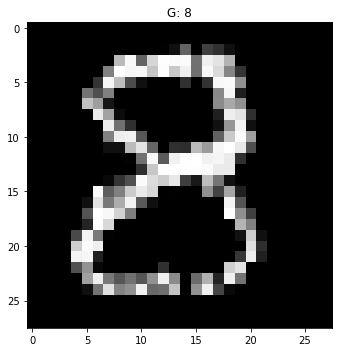

In [23]:
# TODO: Get webcam img and guess

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    # indexes = np.random.choice(len(new_imgs), 2, replace=False)
     
    rows = 1
    cols = 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in range(1):
        image_count += 1
        sub = plt.subplot(rows, cols, image_count)
        imgs = res[idx]
        img = imgs.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[res[idx]]})
        guess_name = mydict[guess[0]]
        # guess_name = str(guess[0])
        # actual_name = str(train_labels[idx])
        actual_name = mydict[train_labels[idx]]
        sub.set_title("G: " + guess_name)
        
    plt.tight_layout()